In [3]:
import os
import glob
import torch
import torchvision
from torchvision import transforms
from PIL import Image
from sklearn.cluster import KMeans
import numpy as np
import math
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

## Importing Cat and dog Dataset 

In [13]:
image_transform = transforms.Compose([transforms.Resize((140,140)),
                                     transforms.ToTensor()])

In [14]:
train_dataset = torchvision.datasets.ImageFolder("dataset/cat_dog/train_set", 
                               transform=image_transform)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                         batch_size=32,
                                         shuffle=True,
                                          pin_memory=True)

test_dataset = torchvision.datasets.ImageFolder("dataset/cat_dog/test_set", 
                               transform=image_transform)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                         batch_size=32,
                                         shuffle=True,
                                          pin_memory=True)

## Visualizing some sample in the data

In [15]:
def visualize_tensor(tensor):
    plt.imshow(np.transpose(tensor, axes=[1,2,0]))
    plt.show()

In [16]:
x,y = next(iter(test_loader))

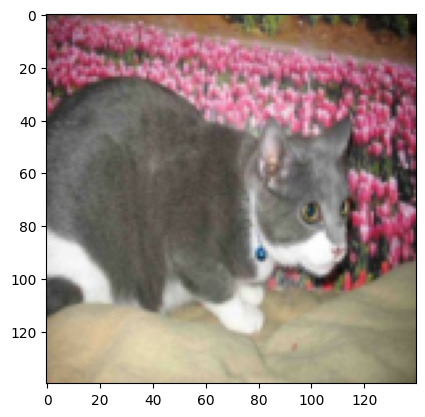

In [17]:
visualize_tensor(x[0])

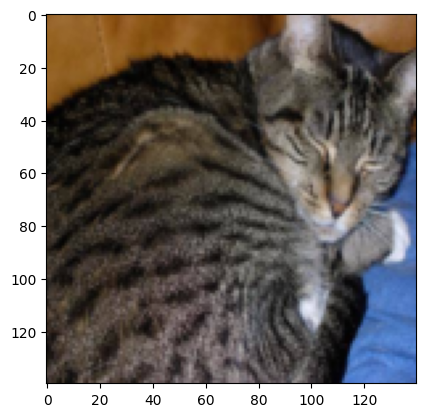

In [18]:
visualize_tensor(x[1])

## Load pretrained dino model

In [19]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [20]:
small_dino = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
# small_dino.to(device) # copy if needed

Using cache found in /Users/daikeig/.cache/torch/hub/facebookresearch_dinov2_main


## Experiement 1: Using pretrain dino to extract feature, then perform a unsupervised labelling

In [21]:
embedding =[]
label = []
for X, y in tqdm(train_loader):
    with torch.no_grad():
        # X, y = X.to(device), y.to(device) # copy if needed
        embedding.append(small_dino(X))
        label.append(y)

X_train = np.concatenate(embedding)

y_train = np.concatenate(label)

embedding =[]
label = []
for X, y in tqdm(test_loader):
    with torch.no_grad():
        # X, y = X.to(device), y.to(device) # copy if needed
        embedding.append(small_dino(X))
        label.append(y)

X_test = np.concatenate(embedding)

y_test = np.concatenate(label)

100%|█████████████████████████████████████████| 157/157 [01:31<00:00,  1.72it/s]


In [24]:
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
model = KMeans(n_clusters=2)
model.fit(np.concatenate([X_train,X_test]))
train_pred = model.predict(np.concatenate([X_train,X_test]))

/opt/homebrew/Caskroom/miniforge/base/envs/dino/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [25]:
# Since we dont know whether 0 is cat or dog, we have to look at both side
max(accuracy_score(np.concatenate([y_train,y_test]),abs(train_pred-1)), accuracy_score(np.concatenate([y_train,y_test]),train_pred))

0.9782